### Task Statement 

Build a prototype of a machine learning model to predict the final temperature of steel.

### Work Plan:

- Preprocessing data: removing outliers, anomalies, filling missing values, combining all datasets into one with features and target columns only.
- Analyzing the data: Comparing the distribution of features in training and test set.
- Model training: Training different regression models with hyperparameter tuning. Evaluating using cross validation and finding the best model.(Using MAE as the evaluation metric)
- Conclusion: Stating findings and results.

### Solution Code:

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score
from catboost import CatBoostRegressor

#### Load Data

In [157]:
temp=pd.read_csv('/datasets/data_temp_en.csv')
electrode=pd.read_csv('/datasets/data_arc_en.csv')
bulk=pd.read_csv('/datasets/data_bulk_en.csv')
wire=pd.read_csv('/datasets/data_wire_en.csv')
gas=pd.read_csv('/datasets/data_gas_en.csv')
data_wire_time=pd.read_csv('/datasets/data_wire_time_en.csv')
data_bulk_time=pd.read_csv('/datasets/data_bulk_time_en.csv')

#### Exploratory Data Analysis and Preprocessing Data

In [158]:
temp.head(15)

,key,Sampling time,Temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [159]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key              15907 non-null int64
Sampling time    15907 non-null object
Temperature      13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [160]:
len(temp['key'].unique())

3216

In [161]:
temp['Sampling time']=pd.to_datetime(temp['Sampling time'])
#temp['time']=temp['Sampling time'].dt.time

In [162]:
temp['Sampling time'].duplicated().sum()

0

In [163]:
time=temp.groupby('key')['Sampling time'].agg(['min','max'])
time

,min,max
key,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39
2,2019-05-03 11:37:27,2019-05-03 11:59:12
3,2019-05-03 12:13:17,2019-05-03 12:34:57
4,2019-05-03 12:52:57,2019-05-03 12:59:25
5,2019-05-03 13:23:19,2019-05-03 13:36:01
...,...,...
3237,2019-08-31 22:44:04,2019-08-31 23:05:43
3238,2019-08-31 23:30:31,2019-08-31 23:43:00
3239,2019-09-01 01:31:47,2019-09-01 02:24:15


In [164]:
time=time.merge(temp,left_on='min',right_on='Sampling time',how='left')

In [165]:
time.head()

,min,max,key,Sampling time,Temperature
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,2,2019-05-03 11:37:27,1581.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,3,2019-05-03 12:13:17,1596.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,4,2019-05-03 12:52:57,1601.0
4,2019-05-03 13:23:19,2019-05-03 13:36:01,5,2019-05-03 13:23:19,1576.0


In [166]:
time=time.drop('Sampling time',axis=1)
time.columns=['min','max','key','temp_min']
time.head()

,min,max,key,temp_min
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,1571.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,2,1581.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,3,1596.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,4,1601.0
4,2019-05-03 13:23:19,2019-05-03 13:36:01,5,1576.0


In [167]:
time['temp_min'].isna().sum()

0

In [168]:
time=time.merge(temp,left_on='max',right_on='Sampling time',how='left')
time.head()

,min,max,key_x,temp_min,key_y,Sampling time,Temperature
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,1571.0,1,2019-05-03 11:30:39,1613.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,2,1581.0,2,2019-05-03 11:59:12,1602.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,3,1596.0,3,2019-05-03 12:34:57,1599.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,4,1601.0,4,2019-05-03 12:59:25,1625.0
4,2019-05-03 13:23:19,2019-05-03 13:36:01,5,1576.0,5,2019-05-03 13:36:01,1602.0


In [169]:
time=time.drop(['key_y','Sampling time'],axis=1)
time.columns=['min','max','key','temp_min','temp_max']
time.head()

,min,max,key,temp_min,temp_max
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,1571.0,1613.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,2,1581.0,1602.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,3,1596.0,1599.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,4,1601.0,1625.0
4,2019-05-03 13:23:19,2019-05-03 13:36:01,5,1576.0,1602.0


In [170]:
#removing missing target rows from the dataset
time.dropna(subset=['temp_max'],inplace=True)

In [171]:
#time['min_day']=time['min'].dt.day
#time['max_day']=time['max'].dt.day
#time['min_month']=time['min'].dt.month
#time['max_month']=time['max'].dt.month
#time['min_hour']=time['min'].dt.hour
#time['max_hour']=time['max'].dt.hour
#time['diff_hour']=time['max_hour']-time['min_hour']
time['min_minute']=time['min'].dt.minute
#time['max_minute']=time['max'].dt.minute
#time['diff_minute']=time['max_minute']-time['min_minute']
time['min_seconds']=time['min'].dt.second
#time['max_seconds']=time['max'].dt.second
#time['diff_seconds']=time['max_seconds']-time['min_seconds']
time['diff']=(time['max']-time['min']).dt.total_seconds()/(60*24*60)

In [172]:
time.describe()

,key,temp_min,temp_max,min_minute,min_seconds,diff
count,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000
mean,1249.968510,1588.405733,1595.334275,29.269277,29.399677,0.021452
std,720.073717,29.232904,16.019339,17.261008,17.233621,0.015067
min,1.000000,1191.000000,1541.000000,0.000000,0.000000,0.000000
25%,628.000000,1572.000000,1587.000000,14.000000,15.000000,0.013669
50%,1251.000000,1588.000000,1593.000000,29.000000,29.000000,0.018414
75%,1872.000000,1605.000000,1599.000000,44.000000,44.000000,0.026181
max,2499.000000,1679.000000,1700.000000,59.000000,59.000000,0.272419


In [173]:
electrode=pd.read_csv('/datasets/data_arc_en.csv')
electrode.head()

,key,Arc heating start,Arc heating end,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [174]:
electrode['Arc heating start']=pd.to_datetime(electrode['Arc heating start'])
electrode['Arc heating end']=pd.to_datetime(electrode['Arc heating end'])

In [175]:
#electrode['start_day']=electrode['Arc heating start'].dt.day
#electrode['start_hour']=electrode['Arc heating start'].dt.hour
#electrode['start_minute']=electrode['Arc heating start'].dt.minute
#electrode['start_seconds']=electrode['Arc heating start'].dt.second

electrode['end_minute']=electrode['Arc heating end'].dt.minute
electrode['end_seconds']=electrode['Arc heating end'].dt.second

electrode['arc_diff']=((electrode['Arc heating end']-electrode['Arc heating start']).
                        dt.total_seconds()/(24*60*60))

In [176]:
electrode.groupby('key').mean().describe()

,Active power,Reactive power,end_minute,end_seconds,arc_diff
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,0.671071,0.445853,29.416921,29.601744,0.001995
std,0.207486,3.163786,9.553584,8.736440,0.000528
min,0.186226,-178.647909,2.000000,0.000000,0.000660
25%,0.519691,0.387213,22.750000,24.000000,0.001620
50%,0.646633,0.489478,29.142857,29.833333,0.001953
75%,0.797201,0.599788,36.000000,35.250000,0.002319
max,1.819169,1.141721,57.000000,58.000000,0.004398


In [177]:
electrode.isna().sum()

key                  0
Arc heating start    0
Arc heating end      0
Active power         0
Reactive power       0
end_minute           0
end_seconds          0
arc_diff             0
dtype: int64

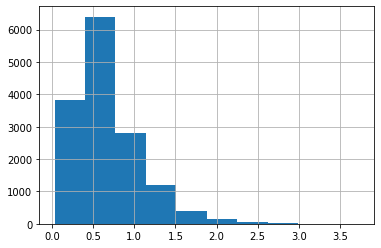

In [178]:
electrode['Active power'].hist()

In [179]:
electrode[electrode['Active power']>2.5].count()/len(electrode)

key                  0.003428
Arc heating start    0.003428
Arc heating end      0.003428
Active power         0.003428
Reactive power       0.003428
end_minute           0.003428
end_seconds          0.003428
arc_diff             0.003428
dtype: float64

In [180]:
electrode=electrode[electrode['Active power']<=2.5]

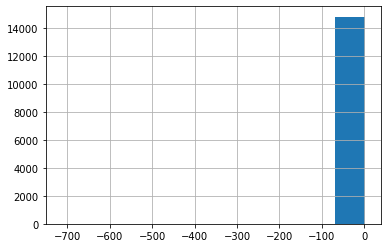

In [181]:
electrode['Reactive power'].hist()

In [182]:
electrode[electrode['Reactive power']<-100].count()/len(electrode)

key                  0.000067
Arc heating start    0.000067
Arc heating end      0.000067
Active power         0.000067
Reactive power       0.000067
end_minute           0.000067
end_seconds          0.000067
arc_diff             0.000067
dtype: float64

In [183]:
electrode=electrode[electrode['Reactive power']>=-100]

Both Active power and reactive power do not contain significant outliers.

In [184]:
power=electrode.groupby('key').mean()

In [185]:
power.head()

,Active power,Reactive power,end_minute,end_seconds,arc_diff
key,,,,,
1,0.975629,0.636648,16.40,25.40,0.002542
2,0.763150,0.499528,45.25,25.50,0.002347
3,0.505176,0.319815,21.00,30.80,0.001516
4,0.802313,0.515074,49.00,32.75,0.002144
5,0.836793,0.563161,24.50,34.75,0.002514


In [186]:
len(power)

3214

In [187]:
bulk=pd.read_csv('/datasets/data_bulk_en.csv')
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [188]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [189]:
bulk=bulk.drop(['Bulk 2','Bulk 7','Bulk 8','Bulk 9','Bulk 5','Bulk 13'],axis=1)

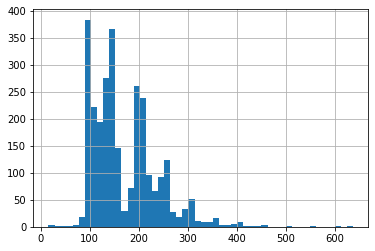

In [190]:
bulk['Bulk 14'].hist(bins=50)

In [191]:
bulk.min()

key         1.0
Bulk 1     10.0
Bulk 3      6.0
Bulk 4     12.0
Bulk 6     17.0
Bulk 10    24.0
Bulk 11     8.0
Bulk 12    53.0
Bulk 14    16.0
Bulk 15     1.0
dtype: float64

No negative values in bulk

In [192]:
#bulk.fillna(0,inplace=True)

In [193]:
wire=pd.read_csv('/datasets/data_wire_en.csv')
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [195]:
wire=wire.drop(['Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9'],axis=1)

In [196]:
#wire.fillna(0,inplace=True)

In [197]:
gas=pd.read_csv('/datasets/data_gas_en.csv')
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Gas 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [198]:
gas.describe()

,key,Gas 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [199]:
gas.head()

,key,Gas 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


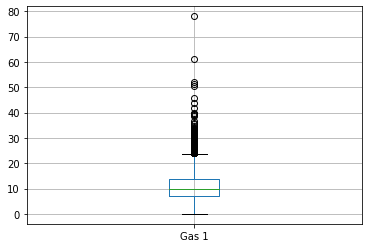

In [200]:
gas.boxplot('Gas 1')

In [201]:
gas=gas[gas['Gas 1']<=30]

#### Creating Features

Joining all datasets to create features

In [202]:
time.set_index('key',inplace=True)

In [203]:
time.head()

,min,max,temp_min,temp_max,min_minute,min_seconds,diff
key,,,,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,16,18,0.009965
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,37,27,0.015104
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,13,17,0.015046
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,52,57,0.004491
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,23,19,0.008819


In [204]:
features=time.join(power)

In [205]:
len(features)

2477

In [206]:
gas=gas.set_index('key')

In [207]:
features=features.join(gas)

In [208]:
bulk=bulk.set_index('key')
wire=wire.set_index('key')

In [209]:
features=features.join([bulk,wire])

In [210]:
features.head()

,min,max,temp_min,temp_max,min_minute,min_seconds,diff,Active power,Reactive power,end_minute,...,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,16.0,18.0,0.009965,0.975629,0.636648,16.40,...,NaN,43.0,NaN,NaN,NaN,206.0,150.0,154.0,60.059998,NaN
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,37.0,27.0,0.015104,0.763150,0.499528,45.25,...,NaN,73.0,NaN,NaN,NaN,206.0,149.0,154.0,96.052315,NaN
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,13.0,17.0,0.015046,0.505176,0.319815,21.00,...,NaN,34.0,NaN,NaN,NaN,205.0,152.0,153.0,91.160157,NaN
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,52.0,57.0,0.004491,0.802313,0.515074,49.00,...,NaN,81.0,NaN,NaN,NaN,207.0,153.0,154.0,89.063515,NaN
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,23.0,19.0,0.008819,0.836793,0.563161,24.50,...,NaN,78.0,NaN,NaN,NaN,203.0,151.0,152.0,89.238236,9.11456


#### Filling missing values

In [211]:
features=features.reset_index()

In [212]:
features['Active power']=features['Active power'].fillna(features['Active power'].mean())

In [213]:
features['Reactive power']=features['Reactive power'].fillna(features['Reactive power'].mean())

In [214]:
features['Gas 1']=features['Gas 1'].fillna(features['Gas 1'].mean())

In [215]:
features=features.fillna(0)

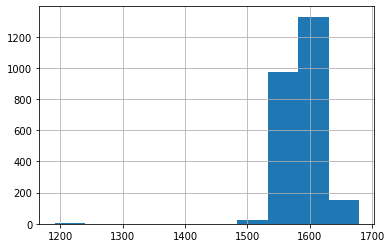

In [216]:
features['temp_min'].hist()

In [217]:
features=features[features['temp_min']>=1500]

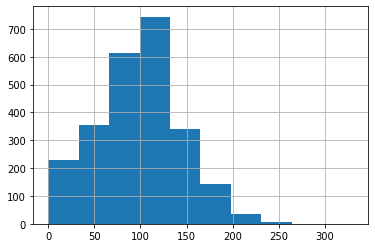

In [218]:
features['Wire 1'].hist()

In [219]:
features['Active power']=features['Active power'].fillna(features['Active power'].mean())

In [220]:
features[features['Wire 1']>220].count()/len(features)

key               0.008896
min               0.008896
max               0.008896
temp_min          0.008896
temp_max          0.008896
min_minute        0.008896
min_seconds       0.008896
diff              0.008896
Active power      0.008896
Reactive power    0.008896
end_minute        0.008896
end_seconds       0.008896
arc_diff          0.008896
Gas 1             0.008896
Bulk 1            0.008896
Bulk 3            0.008896
Bulk 4            0.008896
Bulk 6            0.008896
Bulk 10           0.008896
Bulk 11           0.008896
Bulk 12           0.008896
Bulk 14           0.008896
Bulk 15           0.008896
Wire 1            0.008896
Wire 2            0.008896
dtype: float64

In [221]:
features=features[features['Wire 1']<=220]

In [222]:
x=features.drop(['min','max','temp_max','key'],axis=1)

In [223]:
y=features['temp_max']

In [224]:
x.isna().sum()

temp_min          0
min_minute        0
min_seconds       0
diff              0
Active power      0
Reactive power    0
end_minute        0
end_seconds       0
arc_diff          0
Gas 1             0
Bulk 1            0
Bulk 3            0
Bulk 4            0
Bulk 6            0
Bulk 10           0
Bulk 11           0
Bulk 12           0
Bulk 14           0
Bulk 15           0
Wire 1            0
Wire 2            0
dtype: int64

In [225]:
x.head()

,temp_min,min_minute,min_seconds,diff,Active power,Reactive power,end_minute,end_seconds,arc_diff,Gas 1,...,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
0,1571.0,16.0,18.0,0.009965,0.975629,0.636648,16.40,25.40,0.002542,29.749986,...,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000
1,1581.0,37.0,27.0,0.015104,0.763150,0.499528,45.25,25.50,0.002347,12.555561,...,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000
2,1596.0,13.0,17.0,0.015046,0.505176,0.319815,21.00,30.80,0.001516,28.554793,...,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000
3,1601.0,52.0,57.0,0.004491,0.802313,0.515074,49.00,32.75,0.002144,18.841219,...,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000
4,1576.0,23.0,19.0,0.008819,0.836793,0.563161,24.50,34.75,0.002514,5.413692,...,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456


In [226]:
y.isna().sum()

0

Splitting dataset into train and test

In [227]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=12345)

Comparing the distribution of features in training and test set

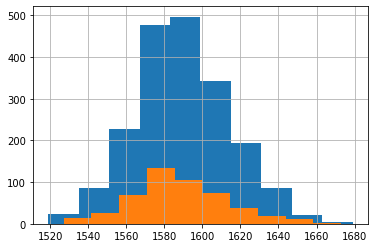

In [228]:
ax=x_train['temp_min'].hist()
x_test['temp_min'].hist(ax=ax)

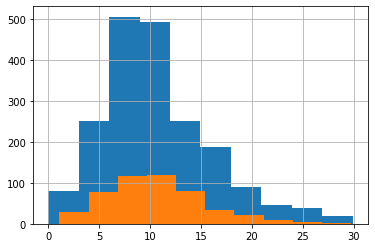

In [229]:
ax=x_train['Gas 1'].hist()
x_test['Gas 1'].hist(ax=ax)

Using Standard Scaler to scale data

In [230]:
scaler=StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

### Model Building 

#### Linear regression

In [231]:
linear=LinearRegression()
linear.fit(x_train,y_train)
y_hat=linear.predict(x_test)
print(mean_absolute_error(y_test,y_hat))

7.681672730223605


Linear Regression will be used as our baseline model

#### RandomForest

In [232]:
rf=RandomForestRegressor(min_impurity_decrease=0.05,random_state=12345)
parameters={'n_estimators':[40,70,100,150],'max_depth':[3,10,40],'min_samples_leaf':[1,3],
            'min_samples_split':[2,10,50]}
clf=GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)

In [233]:
clf.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.05,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=None,
         

In [234]:
clf.best_score_

-7.088866490948078

In [235]:
clf.best_params_

{'max_depth': 40,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 150}

In [236]:
clf.score(x_test,y_test)

-6.5680038622660355

#### XGBoost

In [237]:
xgb=XGBRegressor(objective='reg:squarederror',random_state=12345)
param={'learning_rate':[0.05,0.1,0.3],'max_depth':[3,6,9],
       'n_estimators':[30,60,100,140],'min_child_weight':[1,3,6],
       'gamma': [0.0,0.05,0.5]}
grid=GridSearchCV(xgb,param,scoring='neg_mean_absolute_error',cv=3)

In [238]:
grid.fit(x_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/x

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_st...
                                    reg_lambda=1, scale_pos_weight=1, seed=None,
                                    silent=None, subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.0, 0.05, 0.5],
                         'learning_rate': [0.05, 0.1, 0.3],
                    

In [239]:
grid.best_score_

-6.819811513472577

In [240]:
grid.best_params_

{'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 100}

In [241]:
grid.score(x_test,y_test)

-6.439446660991599

#### LightGBM

In [243]:
d_train = lgb.Dataset(x_train, label=y_train)
params={'objective': 'regression','n_estimators':150,'num_leaves':40,'max_depth':4,
       'learning_rate':0.05,'colsample_bytree':0.7,'reg_alpha':0,'reg_lambda':0.001}
result=lgb.cv(params, d_train, nfold=5, metrics='l1', stratified=False)
print('Best CV score:', result['l1-mean'][-1])


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Best CV score: 6.829459251812946


In [252]:
lgbt=lgb.train(params,d_train)
y_hat=lgbt.predict(x_test)
mean_absolute_error(y_test,y_hat)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


6.581895181914836

#### Catboost

In [245]:
grid={'learning_rate': [0.05,0.08,0.1,0.15,0.3],'l2_leaf_reg':[0.5,1.0,3.0,10.0],
        'depth': [3,4,5,6,8,10], 'n_estimators':[80,100,150,200]}
model=CatBoostRegressor()
result=model.randomized_search(grid,x_train,y_train,cv=3,n_iter=50,
                               partition_random_seed=12345,verbose=False)
print(result['params'])

{'depth': 3, 'iterations': 150, 'learning_rate': 0.08, 'l2_leaf_reg': 0.5}


In [246]:
y_hat=model.predict(x_train)
mean_absolute_error(y_train,y_hat)

6.048188073895001

In [247]:
y_hat=model.predict(x_test)
mean_absolute_error(y_test,y_hat)

6.408440430185722

#### Model Testing

#### Random Forest

In [248]:
rf=RandomForestRegressor(n_estimators=150,max_depth=40,min_samples_split=2,
                         min_impurity_decrease=0.1,min_samples_leaf=3,random_state=12345)
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.1, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [249]:
y_hat=rf.predict(x_test)
mean_absolute_error(y_test,y_hat)

6.56919058282795

#### CatBoost

In [250]:
model=CatBoostRegressor(learning_rate=0.08,iterations=200,max_depth=6,
                        l2_leaf_reg=0.5,random_state=12345,verbose=0)
model.fit(x_train,y_train)
y_hat=model.predict(x_test)
mean_absolute_error(y_test,y_hat)

6.3363215668455535

Catboost performs the best with an MAE of 6.33

### Solution Report

#### Q.What steps of the plan were performed and what steps were skipped (explain why)?

Steps performed:
- Data Preprocessing: Converting date time columns to pandas datetime. Checking for duplicates, filling missing values, removing outliers, converting sampling time and arc heating starting and end time into features by extracting minutes, seconds and taking difference of maximum and minimum in total seconds.
- Comparing the distribution of different features in training and test sets.
- Model training: Trained Linear Regression, Random Forest, XgBoost, LightGBM,CatBoost with hyperparameter tuning.
- Model Testing: Testing the best model on test data\

Steps skipped:
- The missing values in final temperature that is the target variable were dropped instead of filling with mean or median since it impacted the model building negatively and made the model find correlations in data which did not exist. 
- The time of adding bulk and wire feeder were not used as features for model building as there were too many missing values filling which negatively impacted model training.
- Some bulk and wire feeder columns were dropped as features because they contained too missing values and mae increased by using them as features.

#### Q.What difficulties did you encounter and how did you manage to solve them?

Removing outliers, adding time as features and all other steps did not improve the MAE score much. The data set was small hence validation set could not be created. Therefore, I used standard scaling for standardising features and GridSearchCv for hyperparameter tuning and cross validation.

#### Q.What were some of the key steps to solving the task?

Adding the difference of sampling time of first and last temperature in seconds as feature. All models gave high importance to this feature and using GridSearchCv for hyperparameter tuning 

#### Q.What is your final model and what quality score does it have?

Catboost turned out to be the best model with an MAE of 6.33.